In [1]:
# Importing Packages

import os
import re    
import copy
import time
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.sentiment.util import *
from nltk import tokenize
from time import gmtime, strftime
import pandas as pd
import tweepy as tw
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from io import StringIO
from datetime import datetime, timedelta
from datetime import date  
from textblob import TextBlob
#import boto3
#from sagemaker import get_execution_role
#snowballstemmer = SnowballStemmer("english")
#stopwords = stopwords.words('english')

# Uncomment the following lines when running for the first time only, add comment again for second run
#import nltk
#nltk.download('stopwords')
#nltk.download()

#!pip3 install boto3
#!pip install tweepy
#!pip install -U textblob

In [2]:
# This block will authorize twitter API and connect it to my developer account

access_token = "1574192041273094144-9qUjidfpWYpLyLxMAo4b4BMmt4O1xa"
access_token_secret = "uLxLAUxNpTyO2PFq8ZXvljKl6GRDuUZEPLCN0rMd8Y4Uu"
consumer_key = "bvQ8gbYfpUvZ8YOv4dWCUwBLj"
consumer_secret = "reMeIYZKAlyz9wVRo8XDW1xN6t0wl4C0wkM9rtBZMSz58JpWPn"

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

In [3]:
# This block will set user handles from where we will scrape twitter data related to LA Lakers

users = ["Lakers","LakersReporter","LakersNation","lakers_news","LA_Lakers_News","TheLakersReview","LakersTeamShop",
        "VinoUncorked","LakersPulse","thelakers248","LakersCommunity"]


In [4]:
# This block will collect tweets and store them in gathered_tweets list.

gathered_tweets = []
# It will take 1000 tweets from each handle 
for u in users:
    tweets_user_1 = tw.Cursor(api.user_timeline,screen_name=u).items(1000)
    time.sleep(3)
    x = [[tweet.user.screen_name, tweet.text, tweet.created_at] for tweet in tweets_user_1]
    gathered_tweets.append(x)
    time.sleep(3)

In [5]:
# Visual to verify that tweets have been stored in an unorganized manner

gathered_tweets_copy = gathered_tweets.copy()
print ((gathered_tweets))

[[['Lakers', "Brodie ballin' off the bench https://t.co/rbE5FVy1DK", datetime.datetime(2022, 11, 15, 21, 37, 22, tzinfo=datetime.timezone.utc)], ['Lakers', 'RT @mitchell_ness: The @Lakers’ Superman\n\nIn collaboration with the Lakers, Kurt Rambis and @GarrettLeight, we are releasing a limited-edit…', datetime.datetime(2022, 11, 15, 21, 20, 22, tzinfo=datetime.timezone.utc)], ['Lakers', '2017-18 City Edition vs. Showtime Purple', datetime.datetime(2022, 11, 15, 20, 26, 21, tzinfo=datetime.timezone.utc)], ['Lakers', 'Time to decide the GOAT Lakers jersey \n\n@goatfuel | Round Four https://t.co/7tIPhddC5g', datetime.datetime(2022, 11, 15, 20, 26, 20, tzinfo=datetime.timezone.utc)], ['Lakers', '"He\'s been a monster." \n\n@AntDavis23 with the 37-point, 18-rebound performance 〰 https://t.co/Ky7BTQdVV5', datetime.datetime(2022, 11, 15, 1, 4, 6, tzinfo=datetime.timezone.utc)], ['Lakers', 'The Lakers have a tradition of dominant big men like no other. Coach Bill Bertka on Mikan, Wilt, Shaq, an

In [6]:
# Making an organized dataframe out of the list of tweets

data = []
for tw in gathered_tweets:
    for i in enumerate(tw):
        data.append(i[1])
        
tweet_data=pd.DataFrame(data=data, columns=['User','Tweet','Date'])

In [7]:
# Size Check
# This size will be equal to column*rows

tweet_data.size

32070

In [8]:
# Visual verification that dataframe is now organized

tweet_data

,User,Tweet,Date
0,Lakers,Brodie ballin' off the bench https://t.co/rbE5...,2022-11-15 21:37:22+00:00
1,Lakers,RT @mitchell_ness: The @Lakers’ Superman\n\nIn...,2022-11-15 21:20:22+00:00
2,Lakers,2017-18 City Edition vs. Showtime Purple,2022-11-15 20:26:21+00:00
3,Lakers,Time to decide the GOAT Lakers jersey \n\n@goa...,2022-11-15 20:26:20+00:00
4,Lakers,"""He's been a monster."" \n\n@AntDavis23 with th...",2022-11-15 01:04:06+00:00
...,...,...,...
10685,LakersCommunity,RT @LakerGirls: A special morning with the US ...,2015-11-11 19:19:31+00:00
10686,LakersCommunity,RT @LosLakers: ¡Feliz día de los veteranos! 🇺🇸...,2015-11-11 19:19:25+00:00
10687,LakersCommunity,RT @DFenders: Thanks to the US Vets of Inglewo...,2015-11-11 18:21:10+00:00
10688,LakersCommunity,RT @LakerGirls: Honored to be spending this Ve...,2015-11-11 17:22:06+00:00


In [9]:
# This block will store dataframe before data-cleaning as a csv file
# Only run once until you get actual data in form of csv file, comment out for later runs

#tweet_data.to_csv(path_or_buf="C:\\Users\\hardi\\Desktop\\CSUN_Homework\\COMP 541\\Assignment_2\\twitter_data_before_cleaning.csv")

In [10]:
# Removing emoji, http link from text data - Data Cleaning

def remove(x):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"  # flags (Android)
        u"\U000024C2-\U0001F251"  # positional/gps symbols
        u"\U0001f926-\U0001f937"  # Emoji set 2
        u"\U00010000-\U0010ffff"  # Emoji set 3
        u"\u2640-\u2642"          # Emoji set 4
        u"\u2600-\u2B55"          # Emoji set 5
        u"\u200d"                 # Zero width joiner
        u"\u23cf"                 # Eject symbol
        u"\u23e9"                 # black right-pointing double triangles
        u"\u231a"                 # Unicode escape
        u"\ufe0f"                 # dingbats
        u"\u3030"                 # wavy dash
                      "]+", re.UNICODE)
    x = re.sub(emoji_pattern, '', x)
    x = re.sub(r'http\S+', '', x)
    return x
    
tweet_data['Tweet'] = tweet_data['Tweet'].apply(remove)
# print(tweet_data.head(10))

In [11]:
# Visual check post Data Cleaning

print(len(tweet_data))
tweet_data.head(5)

10690


,User,Tweet,Date
0,Lakers,Brodie ballin' off the bench,2022-11-15 21:37:22+00:00
1,Lakers,RT @mitchell_ness: The @Lakers’ Superman\n\nIn...,2022-11-15 21:20:22+00:00
2,Lakers,2017-18 City Edition vs. Showtime Purple,2022-11-15 20:26:21+00:00
3,Lakers,Time to decide the GOAT Lakers jersey \n\n@goa...,2022-11-15 20:26:20+00:00
4,Lakers,"""He's been a monster."" \n\n@AntDavis23 with th...",2022-11-15 01:04:06+00:00


In [12]:
# Total Size and Visual Check post Data Cleaning

tweet_data

,User,Tweet,Date
0,Lakers,Brodie ballin' off the bench,2022-11-15 21:37:22+00:00
1,Lakers,RT @mitchell_ness: The @Lakers’ Superman\n\nIn...,2022-11-15 21:20:22+00:00
2,Lakers,2017-18 City Edition vs. Showtime Purple,2022-11-15 20:26:21+00:00
3,Lakers,Time to decide the GOAT Lakers jersey \n\n@goa...,2022-11-15 20:26:20+00:00
4,Lakers,"""He's been a monster."" \n\n@AntDavis23 with th...",2022-11-15 01:04:06+00:00
...,...,...,...
10685,LakersCommunity,RT @LakerGirls: A special morning with the US ...,2015-11-11 19:19:31+00:00
10686,LakersCommunity,RT @LosLakers: ¡Feliz día de los veteranos! #...,2015-11-11 19:19:25+00:00
10687,LakersCommunity,RT @DFenders: Thanks to the US Vets of Inglewo...,2015-11-11 18:21:10+00:00
10688,LakersCommunity,RT @LakerGirls: Honored to be spending this Ve...,2015-11-11 17:22:06+00:00


In [13]:
# making sure only 1 week of data is parsed from dataframe with clean data

start_date = date.today()
days = timedelta(days = 7)
endDate = start_date - days

tweet_data['Date'] = pd.to_datetime(tweet_data['Date']).dt.date

tweet_data = tweet_data[ (tweet_data['Date'] < start_date) 
                          & (tweet_data['Date'] > endDate)]

In [14]:
# Size and Date visual verification
# Dataframe size will get reduced in this step as we have removed all tweets older than 1 week

tweet_data

,User,Tweet,Date
0,Lakers,Brodie ballin' off the bench,2022-11-15
1,Lakers,RT @mitchell_ness: The @Lakers’ Superman\n\nIn...,2022-11-15
2,Lakers,2017-18 City Edition vs. Showtime Purple,2022-11-15
3,Lakers,Time to decide the GOAT Lakers jersey \n\n@goa...,2022-11-15
4,Lakers,"""He's been a monster."" \n\n@AntDavis23 with th...",2022-11-15
...,...,...,...
8742,thelakers248,Lakers News: The Only Way LeBron James Thinks ...,2022-11-10
8743,thelakers248,Lakers News: LeBron James Isn't Just Consideri...,2022-11-10
8744,thelakers248,Lakers News: Anthony Davis Does Not Mince Word...,2022-11-10
9690,LakersCommunity,A night of Thanksgiving with the Lakers! \n\nI...,2022-11-14


In [15]:
# Actual Sentiment Analysis will start here
# text_list is a list of all individual "tweets"
# The number at the output is the number of sentences or number of tweets

text_list=[]
for tweet in tweet_data["Tweet"]:
    text_list.append(tweet)
len(text_list) 

587

In [54]:
# words is a list of all words from all of the tweets combined

words = nltk.word_tokenize(str(text_list).lower())
len(words) 

10446

In [17]:
# Data Exploration - Stop Word Removal starts here
# We are removing all punctuations and digits in this cell

import string
p = string.punctuation
d = string.digits
table_p = str.maketrans(p, len(p)*' ')
table_d = str.maketrans(d, len(d)*' ')

In [18]:
# Here we make a list of words from all tweets with just punctuations and digits removed
# In the last line we save the frequency distribution for the list we just created - this is before removing stop words

word_lst = []
for word in words:
    no_p = word.translate(table_p)
    no_pd = no_p.translate(table_d)
    no_pds = no_pd.replace(' ', '')
    if len(no_pds) > 1:
        word_lst.append(no_pds)
        
freq = nltk.FreqDist(word_lst)

In [102]:
# We now define the stopwords from the python english corpus and add 'one', 'https' and 'lakers' to it

stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('one')
stopwords.append('https')
stopwords.append('lakers')

stopwords.append('ad')
stopwords.append('nn')
stopwords.append('nt')
stopwords.append('la')
stopwords.append('rt')

In [103]:
# Here we make a frequency distribution of words after the stopword removal

word_lst2 = [w for w in word_lst if w not in stopwords and len(w) > 1]
freq2 = nltk.FreqDist(word_lst2)

Raw text from Twitter


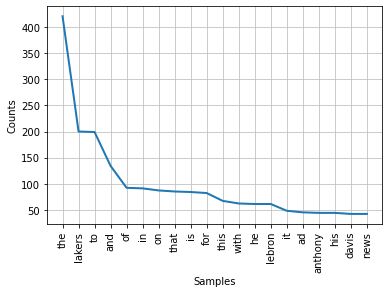

Text with stopwords removed


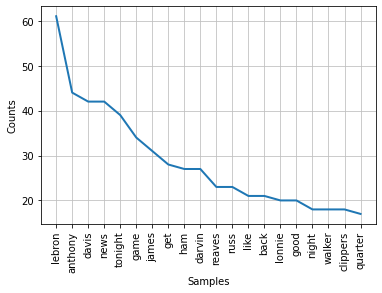

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [104]:
# Making frequency plots of words list before and after stopword removal

print('Raw text from Twitter')
freq.plot(20)

print('Text with stopwords removed')
freq2.plot(20)

In [82]:
# Lemmitization on word list with stopwords removed

from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

lemmatized_list = '\n'.join([lemmatizer.lemmatize(w) for w in word_lst2])

print(lemmatized_list)

brodie
ballin
bench
rt
mitchellness
supermannnin
collaboration
kurt
rambis
garrettleight
releasing
limitededit…
city
edition
v
showtime
purple
time
decide
goat
jersey
nn
goatfuel
round
four
monster
nn
antdavis
point
rebound
performance
tradition
dominant
big
men
like
coach
bill
bertka
mikan
wilt
shaq
more…
twelve
dime
big
block
monster
dunk
brodie
everywhere
last
night
look
ahead
nn
cincoro
lakeshow
wrap
lakerswin
lunch
provided
nn
wegottacos
jackbox
led
way
ending
week
dub
nn
antdavis
pt
rebn
lonniewalker
ptsnaustin
reaves
pts…
lakerswin
lakeshow
austin
lefty
dime
lob
jam
art
quality
halfnn
antdavis
pt
rebn
lonniewalker
pt
⃣nn
suitinguptogether
toyotasocal
game
night
closing
weekend
nn
pmn
spectrumsn
nbatvn
espnla
kwkw
nn
lakeshow
socios
nn
happy
birthday
brodie
tough
pumpfake
spin
move
bucket
two
reaves
close
heading
final
frame
handle
nfootwork
breaknn
antdavis
pt
rebn
russwest
pt
ast
tough
corner
pocket
proud
honor
serviceman
woman
veteran
night
presented
pechangacasino
tonight
sta

In [92]:
# Stemming on word list with lemmitization done

from nltk.stem import PorterStemmer

ps = PorterStemmer()

for w in word_lst2:
    print(w, " : ", ps.stem(w))

brodie  :  brodi
ballin  :  ballin
bench  :  bench
rt  :  rt
mitchellness  :  mitchel
supermannnin  :  supermannnin
collaboration  :  collabor
kurt  :  kurt
rambis  :  rambi
garrettleight  :  garrettleight
releasing  :  releas
limitededit…  :  limitededit…
city  :  citi
edition  :  edit
vs  :  vs
showtime  :  showtim
purple  :  purpl
time  :  time
decide  :  decid
goat  :  goat
jersey  :  jersey
nn  :  nn
goatfuel  :  goatfuel
round  :  round
four  :  four
monster  :  monster
nn  :  nn
antdavis  :  antdavi
point  :  point
rebound  :  rebound
performance  :  perform
tradition  :  tradit
dominant  :  domin
big  :  big
men  :  men
like  :  like
coach  :  coach
bill  :  bill
bertka  :  bertka
mikan  :  mikan
wilt  :  wilt
shaq  :  shaq
more…  :  more…
twelve  :  twelv
dimes  :  dime
big  :  big
block  :  block
monster  :  monster
dunk  :  dunk
brodie  :  brodi
everywhere  :  everywher
last  :  last
night  :  night
look  :  look
ahead  :  ahead
nn  :  nn
cincoro  :  cincoro
lakeshow  :  lak

moved  :  move
gets  :  get
ball  :  ball
block  :  block
aye  :  aye
pat  :  pat
bev  :  bev
good  :  good
thingnngood  :  thingnngood
job  :  job
paint  :  paint
easy  :  easi
money  :  money
fourth  :  fourth
walker  :  walker
knocks  :  knock
pair  :  pair
free  :  free
throws  :  throw
get  :  get
scoring  :  score
started  :  start
tonight  :  tonight
lets  :  let
see  :  see
goesnnball  :  goesnnbal
starting  :  start
lineup  :  lineup
los  :  lo
angeles  :  angel
pat  :  pat
bev  :  bev
reaves  :  reav
fourth  :  fourth
walker  :  walker
brown  :  brown
adnnfor  :  adnnfor
brooklyn  :  brooklyn
sumne…  :  sumne…
statement  :  statement
banned  :  ban
remainder  :  remaind
season  :  season
theecoreyh  :  theecoreyh
hopefully  :  hope
another  :  anoth
night  :  night
suffering  :  suffer
make  :  make
sure  :  sure
follow  :  follow
ln  :  ln
staf…  :  staf…
bron  :  bron
simmons  :  simmon
kyrie  :  kyri
netsnnso  :  netsnnso
vs  :  vs
kd  :  kd
tonight  :  tonight
guys  :  gu

dougieing  :  dougi
right  :  right
ok  :  ok
really  :  realli
would  :  would
like  :  like
clippers  :  clipper
stop  :  stop
answering  :  answer
laker  :  laker
twos  :  two
threes  :  three
love  :  love
burst  :  burst
russ  :  russ
get  :  get
rim  :  rim
first  :  first
bucket  :  bucket
well  :  well
great  :  great
lob  :  lob
nunn  :  nunn
get  :  get
latter  :  latter
first  :  first
basket  :  basket
maybe  :  mayb
positive  :  posit
affirmations  :  affirm
help  :  help
nnplenty  :  nnplenti
game  :  game
left  :  left
turn  :  turn
around  :  around
aaaaaaand  :  aaaaaaand
already  :  alreadi
nni  :  nni
hate  :  hate
well  :  well
paul  :  paul
george  :  georg
certainly  :  certainli
got  :  got
good  :  good
start  :  start
look  :  look
jumper  :  jumper
going  :  go
love  :  love
damn  :  damn
russ  :  russ
got  :  got
finish  :  finish
layup  :  layup
first  :  first
timeout  :  timeout
clippers  :  clipper
knotted  :  knot
austin  :  austin
reaves  :  reav
clamps

james  :  jame
could  :  could
miss  :  miss
multiple  :  multipl
games  :  game
groin  :  groin
injurynn  :  injurynn
news  :  news
verified  :  verifi
fake  :  fake
james  :  jame
twitter  :  twitter
account  :  account
requests  :  request
cavaliers  :  cavali
tradenn  :  tradenn
news  :  news
anthony  :  anthoni
davis  :  davi
flipflops  :  flipflop
asked  :  ask
la  :  la
improvenn  :  improvenn
news  :  news
guess  :  guess
fans  :  fan
want  :  want
trade  :  trade
latest  :  latest
loss  :  loss
nn  :  nn
news  :  news
lowlights  :  lowlight
clippers  :  clipper
predictable  :  predict
victory  :  victori
nn  :  nn
news  :  news
way  :  way
james  :  jame
thinks  :  think
recover  :  recov
sore  :  sore
left  :  left
footnn  :  footnn
news  :  news
james  :  jame
nt  :  nt
considering  :  consid
nba  :  nba
team  :  team
ownership  :  ownership
nn  :  nn
news  :  news
anthony  :  anthoni
davis  :  davi
mince  :  minc
words  :  word
discussing  :  discuss
brutal  :  brutal
start

In [57]:
# collect polarity subjectivity and store the data into list

sub=[]
pol=[]
for dic in text_list:
    text=dic
    tb=TextBlob(text)
    pol.append(tb.sentiment.polarity)
    sub.append(tb.sentiment.subjectivity)

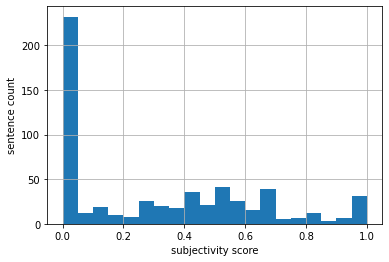

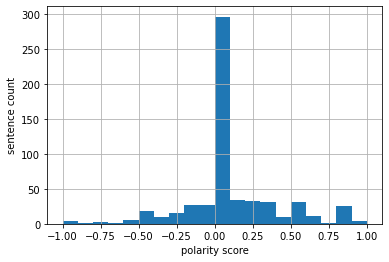

In [58]:
# plot the subjectivity and polarity scores

import matplotlib.pyplot as plt
plt.hist(sub, bins=20) 
plt.xlabel('subjectivity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
plt.hist(pol, bins=20) 
plt.xlabel('polarity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.show()

In [53]:
# Unrevised - code in exrimental format from here
# Second Trial
# nltk.download('vader_lexicon') # only run this line the first time to download dependencies

from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
sia.polarity_scores(text)

{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.836}

In [90]:
def compound(a):
    result=""
    if a>0:
        result="pos"
    elif a==0:
        result="neu"
    else:
        result="neg"
    return result

In [91]:
sias=[]
for dic in text_list:
    #print(dic)
    text=dic
    #tb=TextBlob(text)
    k=sia.polarity_scores(text)["compound"]
    sias.append(conpound(k))

print(sia.polarity_scores(text))

{'neg': 0.0, 'neu': 0.643, 'pos': 0.357, 'compound': 0.836}


In [27]:
final=pd.DataFrame({"tweet":text_list,"sentiment":sias,"Date":tweet_data["Date"]})

print(final.to_markdown())

|      | tweet                                                                                                                                        | sentiment   | Date       |
|-----:|:---------------------------------------------------------------------------------------------------------------------------------------------|:------------|:-----------|
|    0 | Brodie ballin' off the bench                                                                                                                 | neu         | 2022-11-15 |
|    1 | RT @mitchell_ness: The @Lakers’ Superman                                                                                                     | neu         | 2022-11-15 |
|      |                                                                                                                                              |             |            |
|      | In collaboration with the Lakers, Kurt Rambis and @GarrettLeight, we are releasing a limited-edi

In [28]:
# For comparing "neg" value using ctrl + F with total tweets being analyzed.

final.size/3

587.0

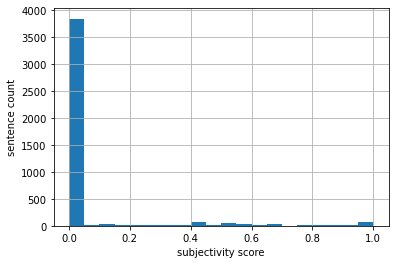

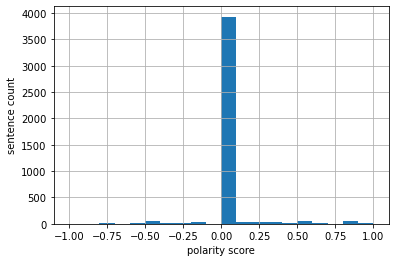

In [29]:
## Test Code from below here
# Experimental code below - Not part of final submission

### collect polarity, subjectivity and store the data into list

sub=[]
pol=[]
for dic in word_lst2:
    text=dic
    tb=TextBlob(text)
    pol.append(tb.sentiment.polarity)
    sub.append(tb.sentiment.subjectivity)
    
# plot the subjectivity and polarity scores

import matplotlib.pyplot as plt
plt.hist(sub, bins=20) 
plt.xlabel('subjectivity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
plt.hist(pol, bins=20) 
plt.xlabel('polarity score')
plt.ylabel('sentence count')
plt.grid(True)
plt.show()